In [10]:
import os
import sqlite3
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import networkx as nx
import dask.bag as db

In [5]:
def print_database_schema(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Get the list of tables in the database
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()

    for table in tables:
        table_name = table[0]
        print(f"Table: {table_name}")

        # Get the schema of the current table
        cursor.execute(f"PRAGMA table_info({table_name});")
        columns = cursor.fetchall()

        for column in columns:
            column_name = column[1]
            column_type = column[2]
            is_nullable = "NOT NULL" if column[3] == 1 else "NULL"
            default_value = column[4]
            is_primary_key = "PRIMARY KEY" if column[5] == 1 else ""

            print(f"  Column: {column_name}")
            print(f"    Type: {column_type}")
            print(f"    Nullable: {is_nullable}")
            print(f"    Default Value: {default_value}")
            print(f"    Primary Key: {is_primary_key}")
            print()

        print()

    conn.close()

db_path = "data/bill_data.db"
print_database_schema(db_path)

Table: bills
  Column: bill_congress
    Type: INTEGER
    Nullable: NULL
    Default Value: None
    Primary Key: PRIMARY KEY

  Column: bill_type
    Type: TEXT
    Nullable: NULL
    Default Value: None
    Primary Key: 

  Column: bill_number
    Type: TEXT
    Nullable: NULL
    Default Value: None
    Primary Key: 

  Column: bill_version
    Type: TEXT
    Nullable: NULL
    Default Value: None
    Primary Key: 

  Column: title
    Type: TEXT
    Nullable: NULL
    Default Value: None
    Primary Key: 

  Column: sponsor_bioguide_id
    Type: TEXT
    Nullable: NULL
    Default Value: None
    Primary Key: 

  Column: sponsor_full_name
    Type: TEXT
    Nullable: NULL
    Default Value: None
    Primary Key: 

  Column: introduced_date
    Type: TEXT
    Nullable: NULL
    Default Value: None
    Primary Key: 

  Column: latest_action_date
    Type: TEXT
    Nullable: NULL
    Default Value: None
    Primary Key: 

  Column: latest_action_text
    Type: TEXT
    Nullable: NULL

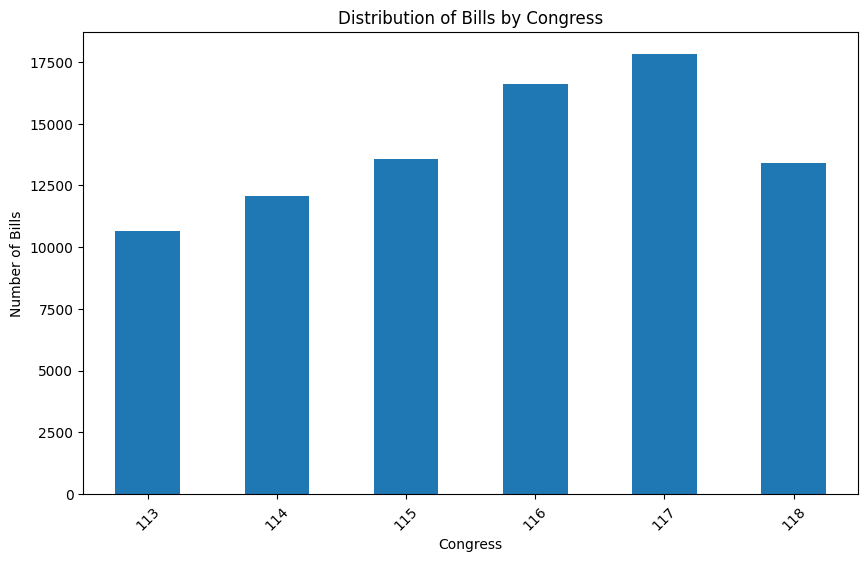

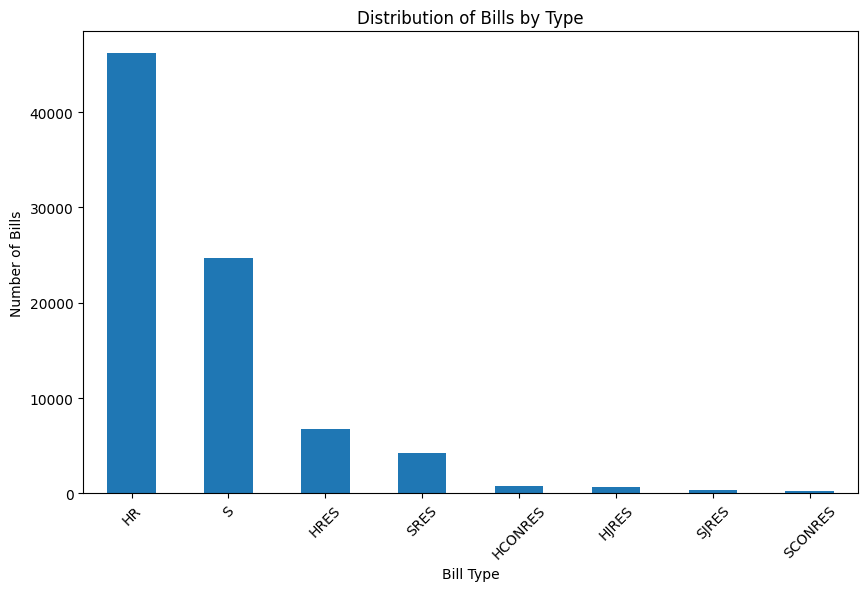

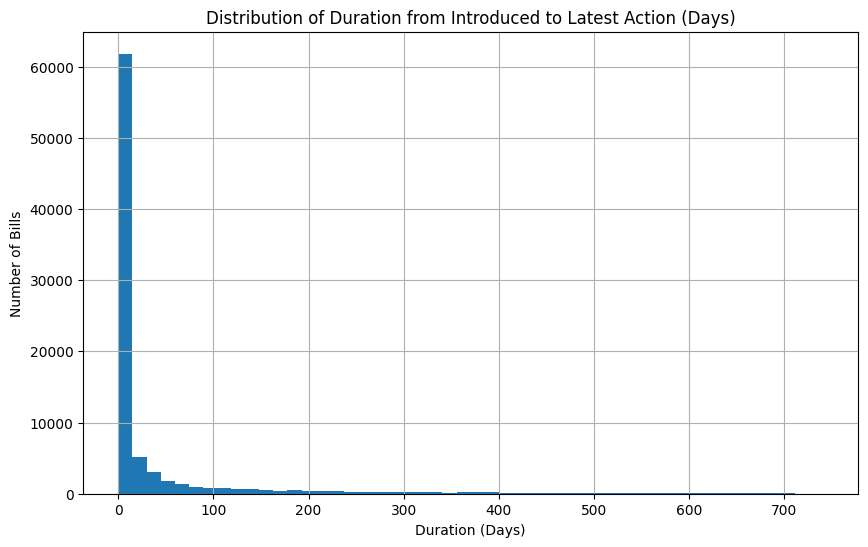

Most Common Cosponsors:
N000147    8470
G000551    5309
C001068    5240
L000551    5188
M000312    5125
S001145    4590
B000574    4359
J000032    4321
P000607    4084
B001277    4055
Name: count, dtype: int64


In [6]:
conn = sqlite3.connect("data/bill_data.db")
cursor = conn.cursor()

# Fetch required fields from bills
query = """
SELECT bill_congress, bill_type, introduced_date, latest_action_date, cosponsors, subjects
FROM bills
"""
cursor.execute(query)
data = cursor.fetchall()

# Convert fetched data into a pandas DataFrame for easier manipulation
df = pd.DataFrame(data, columns=['congress', 'bill_type', 'introduced_date', 'latest_action_date', 'cosponsors', 'subjects'])

# Close the connection now that we've fetched the data
conn.close()

# Convert dates from string to datetime format for calculation
df['introduced_date'] = pd.to_datetime(df['introduced_date'])
df['latest_action_date'] = pd.to_datetime(df['latest_action_date'])

# Calculate the duration from introduced_date to latest_action_date
df['duration_days'] = (df['latest_action_date'] - df['introduced_date']).dt.days

# Convert cosponsors and subjects to lists and filter out Unknown
df['cosponsors'] = df['cosponsors'].apply(lambda x: x.split(',') if x != 'Unknown' else [])
df['subjects'] = df['subjects'].apply(lambda x: x.split(',') if x != 'Unknown' else [])

# Plot distribution of congress
plt.figure(figsize=(10, 6))
df['congress'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Bills by Congress')
plt.xlabel('Congress')
plt.ylabel('Number of Bills')
plt.xticks(rotation=45)
plt.show()

# Plot distribution of bill types
plt.figure(figsize=(10, 6))
df['bill_type'].value_counts().plot(kind='bar')
plt.title('Distribution of Bills by Type')
plt.xlabel('Bill Type')
plt.ylabel('Number of Bills')
plt.xticks(rotation=45)
plt.show()

# Histogram of duration days
plt.figure(figsize=(10, 6))
df['duration_days'].hist(bins=50)
plt.title('Distribution of Duration from Introduced to Latest Action (Days)')
plt.xlabel('Duration (Days)')
plt.ylabel('Number of Bills')
plt.show()

# Most common cosponsors
cosponsor_counts = pd.Series([cosponsor for cosponsors in df['cosponsors'] for cosponsor in cosponsors]).value_counts()
print("Most Common Cosponsors:")
print(cosponsor_counts.head(10))

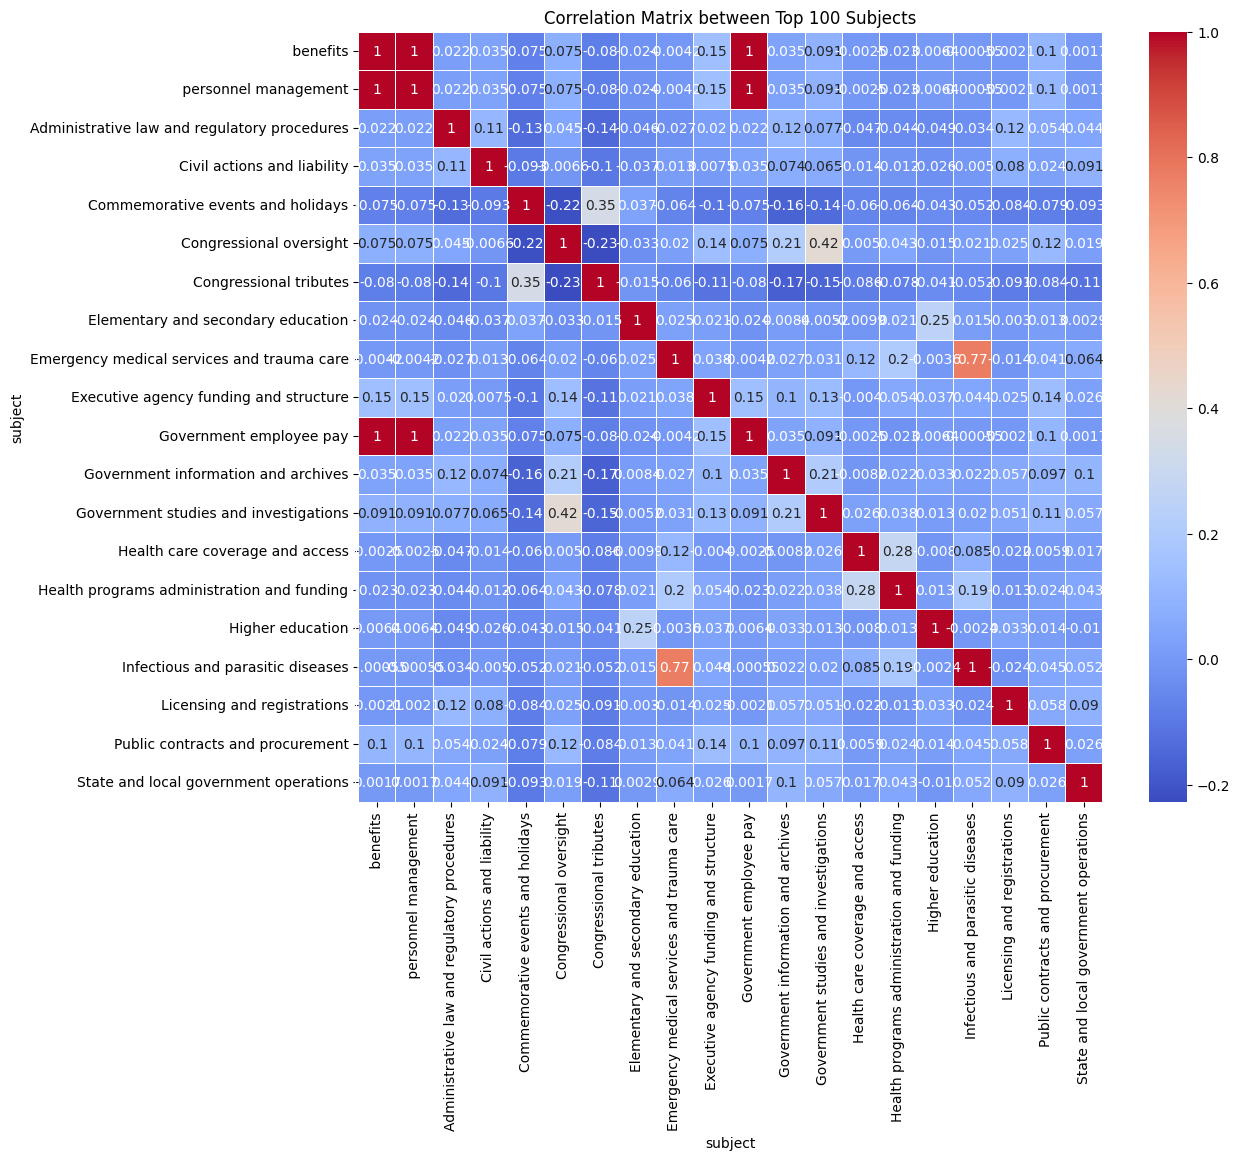

In [7]:
# Most common subjects
subject_counts = pd.Series([subject for subjects in df['subjects'] for subject in subjects]).value_counts()
top_subjects = subject_counts.head(20).index

# Correlation matrix between top subjects
subject_dummies = df['subjects'].apply(lambda x: [subject for subject in x if subject in top_subjects]).apply(pd.Series).stack().reset_index(level=1, drop=True).to_frame('subject')
subject_dummies['value'] = 1
subject_matrix = subject_dummies.pivot_table(index=subject_dummies.index, columns='subject', values='value', fill_value=0)
correlation_matrix = subject_matrix.corr()

# Plot correlation matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix between Top 100 Subjects')
plt.show()

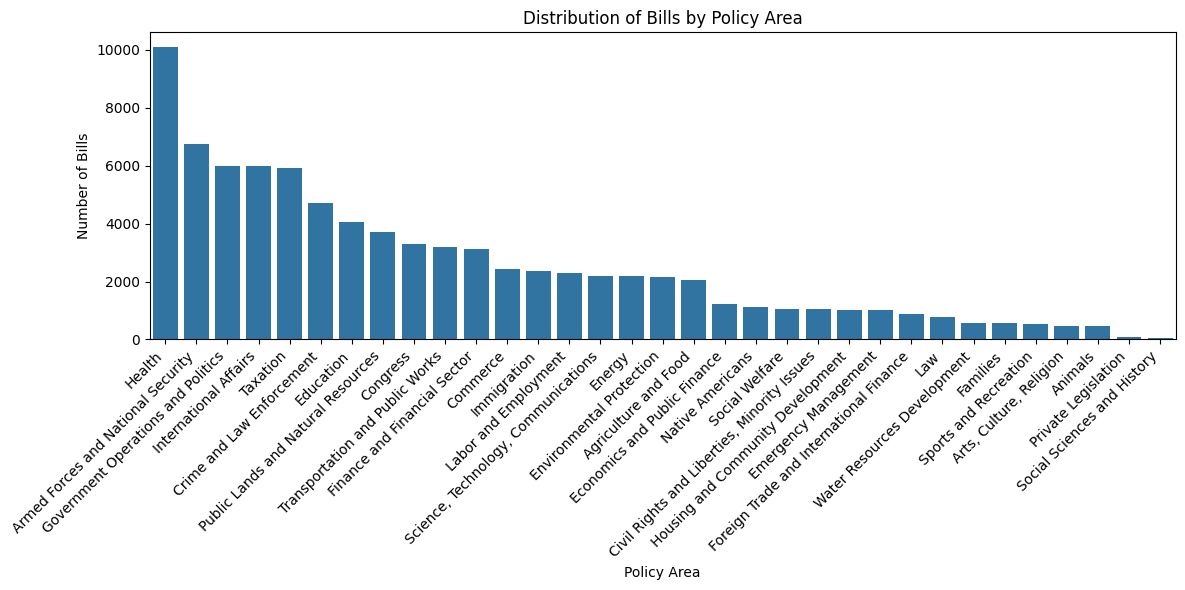

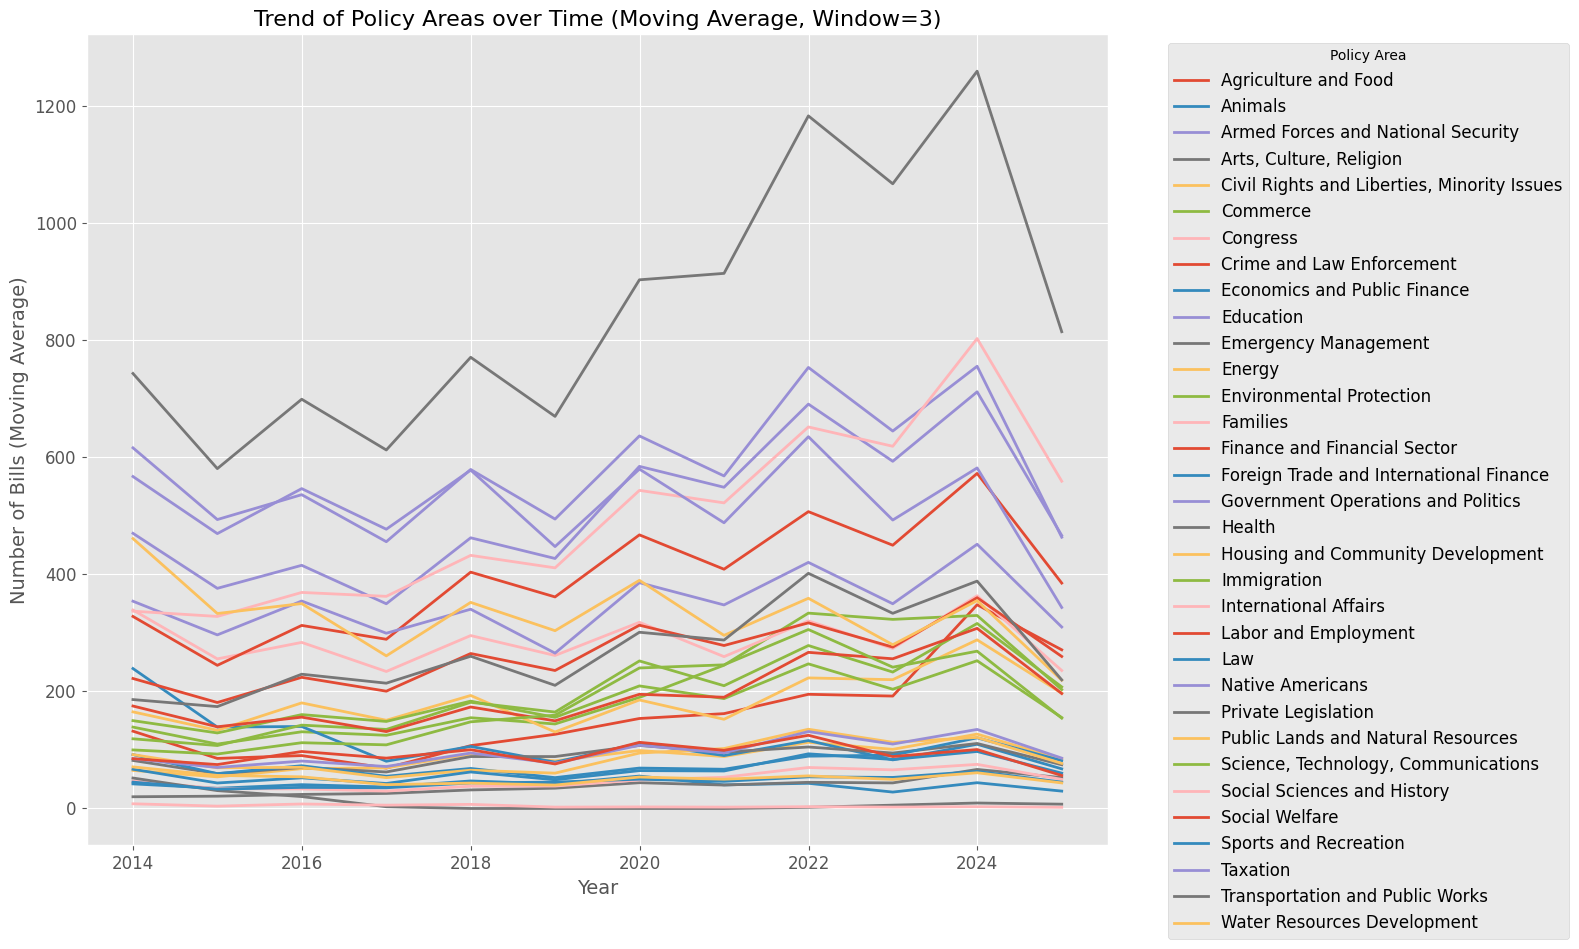

In [8]:
def analyze_bills_by_policy_area(db_path, window=3):
    conn = sqlite3.connect(db_path)
    
    # Query the database to get the policy area and introduced date for each bill
    query = """
        SELECT policy_area, introduced_date
        FROM bills
        WHERE policy_area != 'Unknown'
    """
    df = pd.read_sql_query(query, conn)
    
    # Convert introduced_date to datetime format
    df['introduced_date'] = pd.to_datetime(df['introduced_date'])
    
    # Extract the year from the introduced_date
    df['year'] = df['introduced_date'].dt.year
    
    # Count the number of bills in each policy area
    policy_area_counts = df['policy_area'].value_counts()
    
    # Plot the distribution of bills by policy area
    plt.figure(figsize=(12, 6))
    sns.countplot(x='policy_area', data=df, order=policy_area_counts.index)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Policy Area')
    plt.ylabel('Number of Bills')
    plt.title('Distribution of Bills by Policy Area')
    plt.tight_layout()
    plt.show()
    
    # Analyze trends or patterns in policy areas over time
    policy_area_year_counts = df.groupby(['year', 'policy_area']).size().unstack()
    
    # Fill missing values with 0
    policy_area_year_counts = policy_area_year_counts.fillna(0)
    
    # Set the index as a datetime index
    policy_area_year_counts.index = pd.to_datetime(policy_area_year_counts.index, format='%Y')
    
    # Resample the data by year and interpolate missing values
    policy_area_year_counts = policy_area_year_counts.resample('YE').sum()
    policy_area_year_counts = policy_area_year_counts.interpolate()
    
    # Calculate the moving average for each policy area
    policy_area_year_counts_ma = policy_area_year_counts.rolling(window=window, min_periods=1).mean()
    
    # Plot the trend of policy areas over time with moving average
    plt.figure(figsize=(16, 10))
    plt.style.use('ggplot')
    
    for col in policy_area_year_counts_ma.columns:
        plt.plot(policy_area_year_counts_ma.index, policy_area_year_counts_ma[col], linewidth=2, label=col)
    
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Number of Bills (Moving Average)', fontsize=14)
    plt.title(f'Trend of Policy Areas over Time (Moving Average, Window={window})', fontsize=16)
    plt.legend(title='Policy Area', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    plt.grid(True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()
    
    conn.close()
analyze_bills_by_policy_area(db_path)

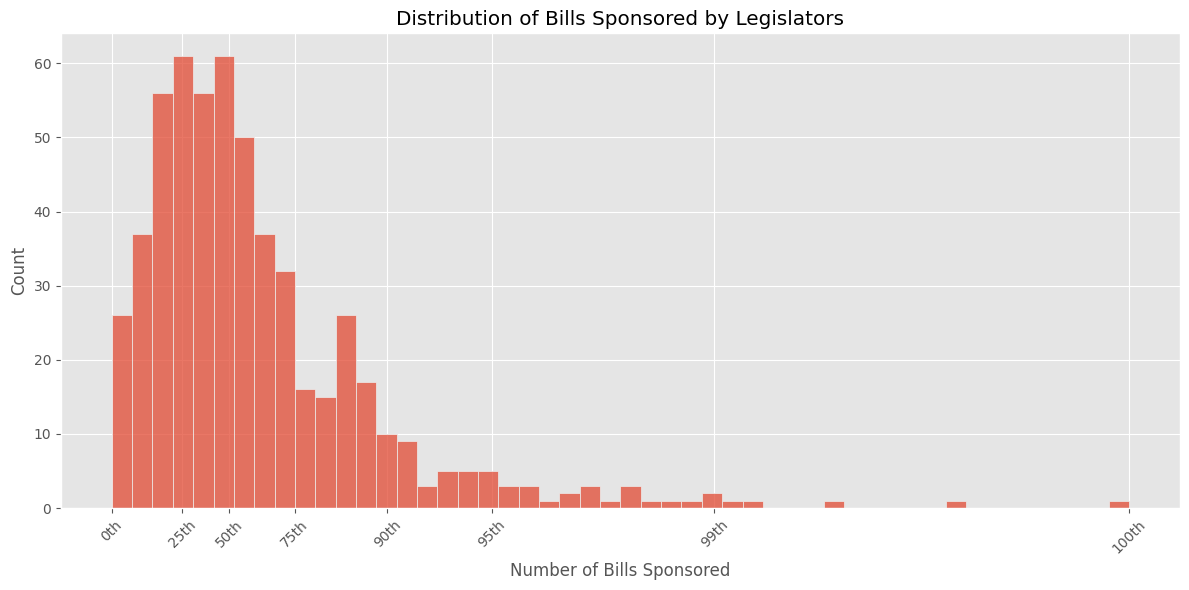

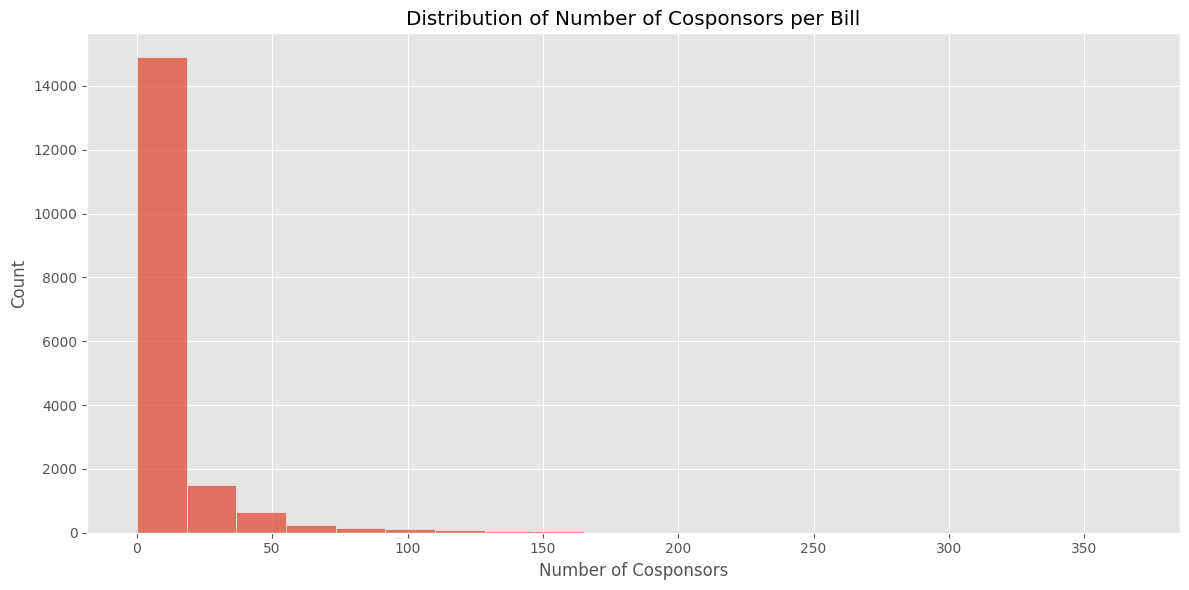

Building cosponsor network:   0%|          | 0/17828 [00:00<?, ?it/s]

Finding Cliques: 0it [00:00, ?it/s]

In [13]:
def analyze_sponsor_cosponsor_relationships(db_path):
    conn = sqlite3.connect(db_path)
    
    # Query the database to get the sponsor, cosponsors, and bill information
    query = """
        SELECT bill_number, sponsor_bioguide_id, cosponsors
        FROM bills
        WHERE bill_congress = 117
    """
    df = pd.read_sql_query(query, conn)
    
    # Count the number of bills sponsored by each legislator
    sponsor_counts = df['sponsor_bioguide_id'].value_counts()
    
    # Calculate percentiles for the number of bills sponsored
    percentiles = [0, 25, 50, 75, 90, 95, 99, 100]
    percentile_values = np.percentile(sponsor_counts, percentiles)
    
    # Plot the distribution of bills sponsored by each legislator using percentiles
    plt.figure(figsize=(12, 6))
    sns.histplot(sponsor_counts, bins=50, kde=False)
    plt.xlabel('Number of Bills Sponsored')
    plt.ylabel('Count')
    plt.title('Distribution of Bills Sponsored by Legislators')
    plt.xticks(percentile_values, [f'{p}th' for p in percentiles], rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Analyze the number of cosponsors for each bill
    df['num_cosponsors'] = df['cosponsors'].apply(lambda x: len(x.split(',')) if x != 'Unknown' else 0)
    
    # Plot the distribution of the number of cosponsors per bill
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x='num_cosponsors', bins=20)
    plt.xlabel('Number of Cosponsors')
    plt.ylabel('Count')
    plt.title('Distribution of Number of Cosponsors per Bill')
    plt.tight_layout()
    plt.show()
    
    # # Create a cosponsor network
    # G = nx.Graph()
    
    # for _, row in tqdm(df.iterrows(), total=len(df), desc='Building cosponsor network'):
    #     sponsor = row['sponsor_bioguide_id']
    #     cosponsors = row['cosponsors'].split(',') if row['cosponsors'] != 'Unknown' else []
        
    #     for cosponsor in cosponsors:
    #         G.add_edge(sponsor, cosponsor)
    
    # cliques = []
    # for clique in tqdm(nx.find_cliques(G), desc="Finding Cliques"):
    #     if len(clique) > 2:
    #         cliques.append(clique)
    
    # # Remove duplicates since a clique can be found multiple times from different nodes
    # frequent_cosponsors = set(tuple(sorted(clique)) for clique in frequent_cosponsors)
    
    # print("Legislators who frequently cosponsor bills together:")
    # for group in frequent_cosponsors:
    #     print(group)
    
    # # Plot the cosponsor network
    # plt.figure(figsize=(12, 12))
    # pos = nx.spring_layout(G)
    # nx.draw_networkx(G, pos, node_size=50, alpha=0.7, edge_color='gray', with_labels=False)
    # plt.axis('off')
    # plt.title('Cosponsor Network')
    # plt.tight_layout()
    # plt.show()
    
    conn.close()

analyze_sponsor_cosponsor_relationships(db_path)